In [3]:
import sys
sys.path.append("../") 
import databasepopulation
import communicationwmongo as commu
import home_location as home
import analysis as a
import pymongo
import my_h3_functions as myh3
import geopandas as gpd
import pandas as pd
from h3 import h3
import datetime
import os, inspect
import matplotlib.pyplot as plt
import importlib
importlib.reload(a)

<module 'analysis' from '../analysis.py'>

In [4]:
db=commu.connecttoLocaldb(database='twitter')

The proposal is to estimate a regression model to test the hypothesis that the growth trend of tweets in tracts  in process of gentrification or at risk of gentrification were higher.

We propose a baseline specification in levels (and logs) as follows :

$$tweets = \beta_0 t+\sum_j \delta_j t Dtypo_j + \sum_t Dyear_t+ \sum_j Dtypo_j + \epsilon $$


$$log(tweets) = \beta_0 t+\sum_j \delta_j t Dtypo_j + \sum_t Dyear_t+ \sum_j Dtypo_j + \epsilon $$



Importantly we will use fixed effects for the aggregation periods in the data (quaterly).



## Step 1. Add census tracts data  to hexs and then aggregate at the tract level

In [5]:
# Get counts at hex level from the database 
df=a.hexcountsresults_to_df(db, save=False)

In [6]:
dfcentroids=myh3.df_with_hexid_to_centroids_gdf(df, hexcolname='_id')

In [7]:
"""
#Omit this cell. I have to use this function because my data is inverted.

from shapely.geometry import Point

def df_with_hexid_to_centroids_gdf(df, hexcolname='hexid'):

    seriesofcoordinates=df[hexcolname].apply(h3.h3_to_geo)
    geometria=seriesofcoordinates.apply(lambda row: Point(row[0],row[1]))
    gdf=gpd.GeoDataFrame(df, geometry=geometria)
    return gdf


dfcentroids=df_with_hexid_to_centroids_gdf(df, hexcolname='_id')
""""""

In [8]:
dfcentroids.head(3)

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time,geometry
0,89dd686e037ffff,1388448000000,1.0,1.0,NaN,1.0,2013-12-31,POINT (-58.63231021289359 -34.26962237322005)
1,89dd686e0b3ffff,1388448000000,10.0,10.0,NaN,10.0,2013-12-31,POINT (-58.64167222372094 -34.2730928847364)
2,89dd6b840b3ffff,1388448000000,1.0,1.0,NaN,1.0,2013-12-31,POINT (-58.28642922668017 -34.91763556397075)


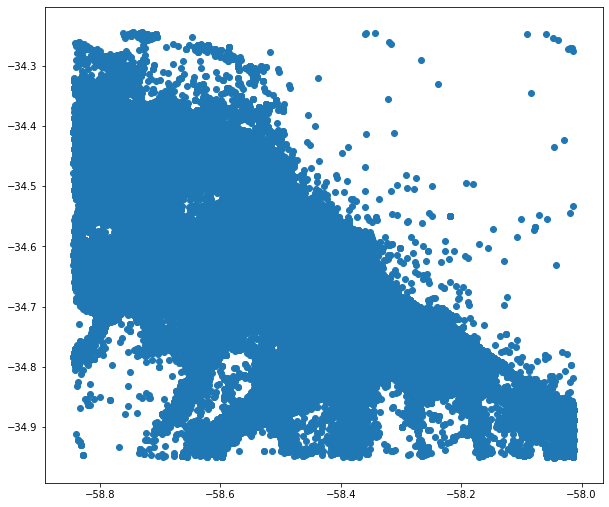

In [9]:
dfcentroids.plot()

In the following, the code spatially joins the tract level data. Be sure that coordinates match. 
I also have to standarize the typologies to the ones in this project 

In [13]:
# Spatial Join
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
tracts = gpd.read_file(currentdir+'/../data/radios_amba_2010.shp')
tracts=tracts.to_crs({'init': 'epsg:4326'})

# Spatial Join between centroids and census track shapes
dfcentroids=gpd.sjoin(dfcentroids, tracts, how="inner", op='intersects')

# Since in my case I do not have the typologies with the census tract data, I still need to merge it by censustrackid
typologies=pd.read_excel(currentdir+'/../data/tipologias/'+'tipologias.xlsx')


typologies.loc[typologies['TYPE']=='GDV','TYPE' ]="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='GD','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='GV','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='G','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='DV','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='D','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='VE','TYPE']="Exclusive Dynamic"
typologies.loc[typologies['TYPE']=='V','TYPE']="Low Income, At Risk of Change"
typologies.loc[typologies['TYPE']=='E','TYPE']="Exclusive Static"


dfcentroids=dfcentroids.merge(typologies[['COD_2010','TYPE']], left_on='cod_radio', right_on='COD_2010')

/home/rickhunter/miniconda3/envs/prueba/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rickhunter/miniconda3/envs/prueba/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rickhunter/miniconda3/envs/prueba/lib/python3.6/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


In [71]:
# As you can see the data now incorporates the typologies
dfcentroids.head(3)

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time,geometry,index_right,cod_radio,...,tipo,cloc_urb,nom_urb,cloc_agrup,nom_agrup,cloc_dispe,nom_disper,localidad,COD_2010,TYPE
0,89dd6b81c67ffff,1364688000000,1.0,1.0,NaN,1.0,2013-03-31,POINT (-58.34666332914924 -34.61369860536405),1241,20011314,...,U,1.0,COMUNA 01,NaN,None,NaN,None,CABA,20011314,"Low Income, At Risk of Change"
1,89dd6b81c67ffff,1372550400000,0.0,0.0,NaN,0.0,2013-06-30,POINT (-58.34666332914924 -34.61369860536405),1241,20011314,...,U,1.0,COMUNA 01,NaN,None,NaN,None,CABA,20011314,"Low Income, At Risk of Change"
2,89dd6b81c67ffff,1380499200000,0.0,0.0,NaN,0.0,2013-09-30,POINT (-58.34666332914924 -34.61369860536405),1241,20011314,...,U,1.0,COMUNA 01,NaN,None,NaN,None,CABA,20011314,"Low Income, At Risk of Change"


## Aggregating the data at the tract level

COD_2010 corresponds to the tract level code id from Buenos Aires

In [73]:
df_tract_level=dfcentroids[['nonresidents','nonresidentsandnonneighbors','residents','totalcounts','COD_2010','time']].groupby(['COD_2010','time']).sum().reset_index()
typologies_code=dfcentroids[['COD_2010','TYPE']].drop_duplicates()
df_tract_level=df_tract_level.merge(typologies_code, left_on='COD_2010', right_on='COD_2010')
df_tract_level.head(3)

,COD_2010,time,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,TYPE
0,20010101,2012-09-30,995.0,970.0,39.0,1034.0,"Low Income, Undergoing Change"
1,20010101,2012-12-31,1996.0,1969.0,66.0,2062.0,"Low Income, Undergoing Change"
2,20010101,2013-03-31,2756.0,2662.0,592.0,3348.0,"Low Income, Undergoing Change"


In [74]:
df_tract_level.TYPE.unique()

array(['Low Income, Undergoing Change', 'Low Income, At Risk of Change',
       'Exclusive Static', 'OTHER', 'Exclusive Dynamic', 'NON POP',
       'NON_POP'], dtype=object)

# Regression Analysis

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [78]:
df_tract_level['days']=(df_tract_level.time-datetime.datetime(2012,9,30)).dt.days

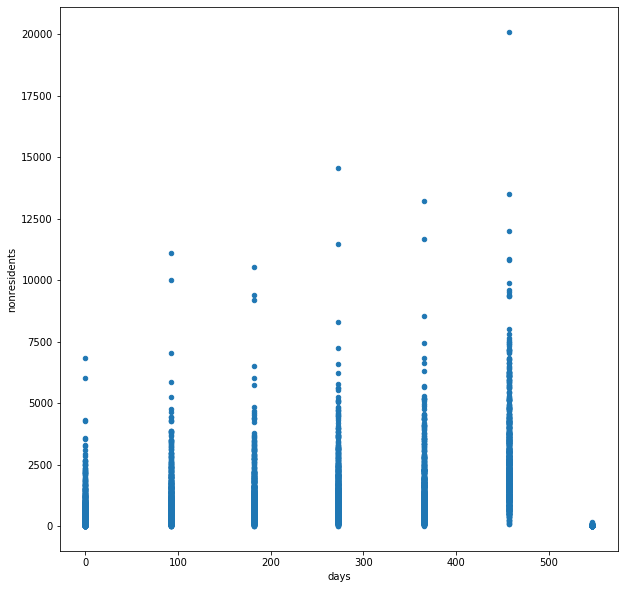

In [79]:
df_tract_level.plot.scatter(x='days',y='nonresidents')
#ojo voy a tener que controlar por la muestra porque el ultimo periodo tiene menos datos

In [80]:
df_tract_level['lognonresidents']=np.log(df_tract_level.nonresidents)

/home/rickhunter/miniconda3/envs/prueba/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


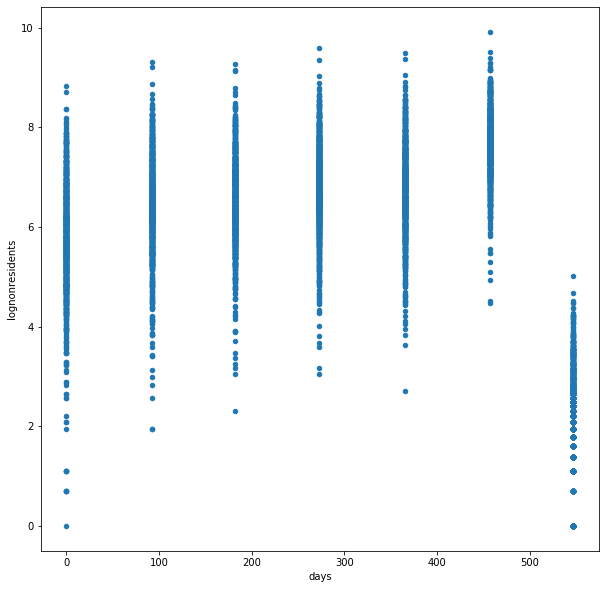

In [81]:
df_tract_level.plot.scatter(x='days',y='lognonresidents')

In [82]:
datos=df_tract_level[['lognonresidents','nonresidents','days','TYPE','time']]
# el metodo dropna() me permite eliminar las filas que tienen algun valor missing
datos=datos.dropna()

In [87]:
datos=datos.loc[datos.nonresidents>0]

In [88]:
import numpy as np
results = smf.ols('lognonresidents ~  days*C(TYPE)+ C(time)', data=datos).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        lognonresidents   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     1194.
Date:                Sat, 12 Sep 2020   Prob (F-statistic):               0.00
Time:                        11:57:02   Log-Likelihood:                -7877.8
No. Observations:                6221   AIC:                         1.579e+04
Df Residuals:                    6202   BIC:                         1.592e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [89]:
import numpy as np
results = smf.ols('nonresidents ~  days*C(TYPE)+ C(time)', data=datos).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           nonresidents   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     218.9
Date:                Sat, 12 Sep 2020   Prob (F-statistic):               0.00
Time:                        11:57:05   Log-Likelihood:                -52134.
No. Observations:                6221   AIC:                         1.043e+05
Df Residuals:                    6202   BIC:                         1.044e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------